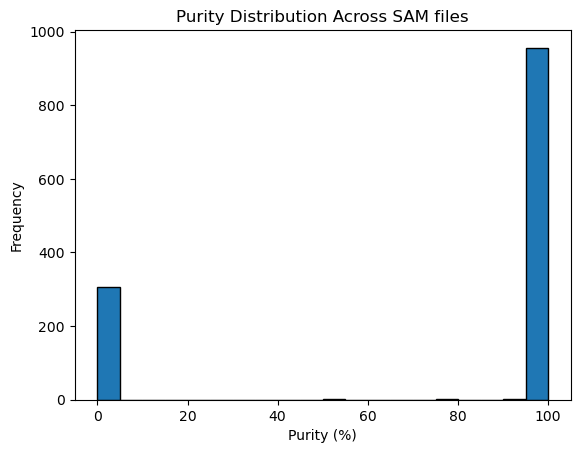

In [ ]:
import os
import pysam
import matplotlib.pyplot as plt
import numpy as np


def analyze_sam_file(filepath):
    samfile = pysam.AlignmentFile(filepath, "r")
    total_reads = set()
    microbe_count = {}
    unmatched_reads = 0
    
    for read in samfile:
        read_name = read.query_name
        microbe_name = read.reference_name
        
        if microbe_name == "*":
            unmatched_reads += 1
            continue

        if read_name not in total_reads:
            total_reads.add(read_name)
            if read.mapping_quality >= 40:
                microbe_count[microbe_name] = microbe_count.get(microbe_name, 0) + 1

    samfile.close()

    total_read_count = len(total_reads) + unmatched_reads

    if len(microbe_count) == 0:
        return 0, total_read_count, None  # Return None if no microbes are found

    most_common_microbe = max(microbe_count, key=microbe_count.get)
    purity = (microbe_count[most_common_microbe] / total_read_count) * 100 if total_read_count != 0 else 0
    return purity, total_read_count, most_common_microbe


def write_results_to_file(results, output_path):
    with open(output_path, "w") as file:
        file.write("Filename, Purity (%), Most Common Microbe\n")
        for filename, (purity, _, microbe) in results.items():
            file.write(f"{filename}, {purity:.2f}, {microbe or 'None'}\n")


folder_path = "./minimap2_output_many_seqs"  #replace to minimap result directory
results = {}
purity_list = []
read_count_dict = {}

for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        filepath = os.path.join(folder_path, filename)
        purity, total_reads, most_common_microbe = analyze_sam_file(filepath)
        
        purity_list.append(purity)
        results[filename] = (purity, total_reads, most_common_microbe)
        
        if total_reads not in read_count_dict:
            read_count_dict[total_reads] = 0
        read_count_dict[total_reads] += 1

# output_path
output_path = "/purity_minimap.txt"
write_results_to_file(results, output_path)
bins = np.arange(0, 105, 5)
plt.hist(purity_list, bins=bins, edgecolor='black')
plt.title('Purity Distribution Across SAM files')
plt.xlabel('Purity (%)')
plt.ylabel('Frequency')
plt.show()
